In [1]:
import numpy as np
import mpmath 
import matplotlib.pyplot as plt
from IPython.display import Audio
import math as mth
from time import time
from contextlib import contextmanager
from scipy import linalg, signal, constants, optimize

In [2]:
if False:
    data = np.loadtxt('rho_30dots_fix(1).dat')
    rho_00_dot1 = data[:,0]
    rho_01_dot1 = data[:,1] + 1j*data[:,2]

    rho_00_dot2 = data[:,4]
    rho_01_dot2 = data[:,5] + 1j*data[:,6]
    
    rho_00_dot3 = data[:,8]
    rho_01_dot3 = data[:,9] + 1j*data[:,10]

    rho_00_dot4 = data[:,12]
    rho_01_dot4 = data[:,13] + 1j*data[:,14]
    
    rho_00_dot5 = data[:,16]
    rho_01_dot5 = data[:,17] + 1j*data[:,18]

    data = np.loadtxt('rho_2dots_dt5e-5_fix_nint.dat')
    rho_00_dot1_nint = data[:,0]
    rho_01_dot1_nint = data[:,1] + 1j*data[:,2]

    rho_00_dot2_nint = data[:,4]
    rho_01_dot2_nint = data[:,5] + 1j*data[:,6]
    
    data = np.loadtxt('dots30_configuration.txt')
    x_coord = data[:,0]
    y_coord = data[:,1]
    z_coord = data[:,2]

    np.savez('Elliot_30dot_data.npz',rho_00_dot1=rho_00_dot1,
        rho_01_dot1=rho_01_dot1,
        rho_00_dot2=rho_00_dot2,
        rho_01_dot2=rho_01_dot2,
        rho_00_dot3=rho_00_dot3,
        rho_01_dot3=rho_01_dot3,
        rho_00_dot4=rho_00_dot4,
        rho_01_dot4=rho_01_dot4,
        rho_00_dot5=rho_00_dot5,
        rho_01_dot5=rho_01_dot5,
        rho_00_dot1_nint=rho_00_dot1_nint,
        rho_01_dot1_nint=rho_01_dot1_nint,
        rho_00_dot2_nint=rho_00_dot2_nint,
        rho_01_dot2_nint=rho_01_dot2_nint,
             x_coord=x_coord,
             y_coord=y_coord,
             z_coord=z_coord)

In [3]:
data = np.load('Elliot_30dot_data.npz')
rho_00_dot1 = data['rho_00_dot1']
rho_01_dot1 = data['rho_01_dot1']
rho_00_dot2 = data['rho_00_dot2']
rho_01_dot2 = data['rho_01_dot2']
rho_00_dot3 = data['rho_00_dot3']
rho_01_dot3 = data['rho_01_dot3']
rho_00_dot4 = data['rho_00_dot4']
rho_01_dot4 = data['rho_01_dot4']
rho_00_dot5 = data['rho_00_dot5']
rho_01_dot5 = data['rho_01_dot5']
rho_00_dot1_nint = data['rho_00_dot1_nint']
rho_01_dot1_nint = data['rho_01_dot1_nint']
rho_00_dot2_nint = data['rho_00_dot2_nint']
rho_01_dot2_nint = data['rho_01_dot2_nint']
x_coord = data['x_coord']
y_coord = data['y_coord']
z_coord = data['z_coord']

In [4]:
@contextmanager
def timer(prefix=None):
    t_start = time()
    yield
    t_end = time()
    t = t_end - t_start
    
    minutes = np.floor(t / 60)
    seconds = t % 60
    if prefix is None:
        print(minutes,'minutes',seconds,'seconds')
        
    else:
        print(prefix+':',minutes,'minutes',seconds,'seconds')

In [5]:
def get_uvw(rho_00,rho_01):
    u = 2*rho_01.real
    v = 2*rho_01.imag
    w = 1-2*rho_00
    return u,v,w

In [6]:
u1_elliot,v1_elliot,w1_elliot = get_uvw(rho_00_dot1,rho_01_dot1)
u2_elliot,v2_elliot,w2_elliot = get_uvw(rho_00_dot2,rho_01_dot2)
u3_elliot,v3_elliot,w3_elliot = get_uvw(rho_00_dot3,rho_01_dot3)
u4_elliot,v4_elliot,w4_elliot = get_uvw(rho_00_dot4,rho_01_dot4)
u5_elliot,v5_elliot,w5_elliot = get_uvw(rho_00_dot5,rho_01_dot5)

u1_elliot_nint,v1_elliot_nint,w1_elliot_nint = get_uvw(rho_00_dot1_nint,rho_01_dot1_nint)
u2_elliot_nint,v2_elliot_nint,w2_elliot_nint = get_uvw(rho_00_dot2_nint,rho_01_dot2_nint)

t_elliot = np.linspace(0,10,u1_elliot.size)

In [7]:
def compare_frequency_spectra_solutions(signal_t_1,signal_t_2,t,minimum_f=None,maximum_f=None,sol=' Guess',vline=False):
    #plots the freq spec for a given signal.  minimum_f and maximum_f must be in Hz. signal is the variable name
    stop_time = t[-1]
    dt = stop_time/t.size
    
    Signal_w_1 = np.fft.fftshift(np.fft.fft(signal_t_1))
    Signal_w_2 = np.fft.fftshift(np.fft.fft(signal_t_2))
    freq = np.fft.fftshift(np.fft.fftfreq(signal_t_1.size,dt))

   
    plt.figure()
    plt.semilogy(freq,abs(Signal_w_1),label='Chad'+sol)
    plt.semilogy(freq,abs(Signal_w_2),label='Elliot Solution')
    if vline == True:
        for frequency in omega_k/(2*np.pi):
            plt.axvline(frequency,c='k')
    plt.legend()
    plt.grid()
    plt.xlabel('Linear Frequency')
    plt.xlim(minimum_f,maximum_f)
    plt.ylabel('|Magnitude|')

    plt.figure()
    plt.plot(freq,np.angle(Signal_w_1,deg=True),label='Chad'+sol)
    plt.plot(freq,np.angle(Signal_w_2,deg=True),label='Elliots Solution')
    if vline == True:
        for frequency in omega_k/(2*np.pi):
            plt.axvline(frequency,c='k')
    plt.ylabel('Phase (degrees)')
    plt.xlabel('Linear Frequency')
    plt.xlim(minimum_f,maximum_f)
    plt.legend()

In [8]:
#General Parameters
num_dots = 2
omega_0 = 2278.9013 # in rad/picosecond
period = 2*np.pi/omega_0
f0 = omega_0 / (2*np.pi)

stop_time = 10 #in picoseconds

#Dot parameters
sigma = 2278.9013
t0 = 0.0
hbar = 0.65821193
T1 = 1e6
T2 = 2e6
x_coord = np.array([0.0,0.0])
y_coord = np.array([-0.00175,0.00175])
z_coord = x_coord

#Misc Parameters
x_hat = np.array([1,0,0])
y_hat = np.array([0,1,0])
r_hat_dot1 = np.array([0,1,0])
r_hat_dot2 = np.array([0,-1,0])

c0 = 299.792458 #um/ps
mu0 = 2.0133545e-04
eps0 = 1/(mu0*c0**2)
d = 5.2917721e-4
d_vector = d*x_hat
E0 = 1558.8929

omega_r = d*E0/hbar
# f_r = 2.2669
#omega_r = 2*np.pi*f_r

In [9]:
delta_f = 0.1
delta_omega = 2*np.pi*delta_f
B = 4
C = 6
i = np.arange(-B,B+1)
j = np.arange(-B,B+1)
k = np.arange(-C,C+1)

i,j = np.meshgrid(i,j)
ij_sum_abs = abs(i) + abs(j)
ij = ij_sum_abs<=B
i = i[ij]
j = j[ij]
#k = k[ij]

omega_k = i * omega_0 + j * omega_r
omega_k = np.sort(omega_k)
omega_k = np.unique(omega_k)

num_frequencies = omega_k.size
num_coefficients = num_frequencies
num_unknowns = num_dots*3*num_coefficients
degrees_of_freedom_remaining = int(num_unknowns - 3*num_dots)
num_tests = int(degrees_of_freedom_remaining / (3*num_dots))
print('Solving',num_frequencies,'frequencies')
print('Solving',num_coefficients,'coefficients per signal')
print('Solving',num_unknowns,'degrees of freedom')

Solving 41 frequencies
Solving 41 coefficients per signal
Solving 246 degrees of freedom


In [10]:
Rx = x_coord[:,np.newaxis] - x_coord[:,np.newaxis].T
Ry = y_coord[:,np.newaxis] - y_coord[:,np.newaxis].T
Rz = z_coord[:,np.newaxis] - z_coord[:,np.newaxis].T

dots_to_R = np.sqrt(Rx**2 + Ry**2 + Rz**2)
Rdiag = np.diag(np.ones(x_coord.size))

dots_to_R += Rdiag
dots_to_R_vector = np.concatenate((Rx[:,:,np.newaxis],Ry[:,:,np.newaxis],Rz[:,:,np.newaxis]),axis = 2)
rhats = dots_to_R_vector / dots_to_R[:,:,np.newaxis]

In [11]:
dots = np.arange(num_dots)
rec_to_rad = np.zeros((num_dots,num_dots),dtype=int)
for dot in rec_to_rad:
    dot += dots
for i,rec in enumerate(rec_to_rad):
    for j,rad in enumerate(rec):
        if i==j:
            rec_to_rad[i,j] = -1
rec_to_rad = np.sort(rec_to_rad)
rec_to_rad = rec_to_rad[:,1:]

In [12]:
def get_gamma(t):
    #Creates a matrix of trigonometric basis functions
    return np.exp(1j*omega_k*t[:,np.newaxis])

In [13]:
def get_gamma_t0(t0):
    #Creates a matrix of trigonometric basis functions evaluated at an instant in time, t0
    #Used for enforcing initial conditions in the Newton Solver
    return np.exp(1j*omega_k*t0)

In [14]:
def get_gamma_prime(t):
    #Creates a matrix of derivatives of trig basis functions
    return 1j*omega_k*np.exp(1j*omega_k*t[:,np.newaxis])

In [15]:
def get_gamma_double_prime(t):
    #Second derivative matrix
    return -omega_k**2*np.exp(1j*omega_k*t[:,np.newaxis])

In [16]:
def get_rhos(u,v,w):
    rho_00 = 0.5 - 0.5*w
    rho_01 = 0.5*u + 0.5j*v
    return rho_00, rho_01

In [17]:
def get_P(u_coeff,v_coeff,w_coeff,t,R):
    #Evaluates the polarization
    delay = t - (R/c0)
    gamma_delay = get_gamma(delay)
    
    u_delay = gamma_delay@u_coeff
    v_delay = gamma_delay@v_coeff
    w_delay = gamma_delay@w_coeff
    
    rho_00_delay,rho_01_delay = get_rhos(u_delay,v_delay,w_delay)
    
    P = 2*(rho_01_delay.real)*d_vector[:,np.newaxis]
    
    return P

In [18]:
def get_P_prime(u_coeff,v_coeff,w_coeff,t,R):
    delay = t - (R/c0)
    gamma_prime_delay = get_gamma_prime(delay)
    u_prime_delay = gamma_prime_delay@u_coeff
    v_prime_delay = gamma_prime_delay@v_coeff
    w_prime_delay = gamma_prime_delay@w_coeff
    
    rho_00_prime_delay,rho_01_prime_delay = get_rhos(u_prime_delay,v_prime_delay,w_prime_delay)
    P_prime = 2*(rho_01_prime_delay.real)*d_vector[:,np.newaxis]
    
    return P_prime

In [19]:
def get_P_doubleprime(u_coeff,v_coeff,w_coeff,t,R):
    delay = t - (R/c0)
    gamma_doubleprime = get_gamma_double_prime(delay)
    u_doubleprime_delay = gamma_doubleprime@u_coeff
    v_doubleprime_delay = gamma_doubleprime@v_coeff
    w_doubleprime_delay = gamma_doubleprime@w_coeff
    
    rho_00_doubleprime_delay,rho_01_doubleprime_delay = get_rhos(u_doubleprime_delay,v_doubleprime_delay,w_doubleprime_delay)
    P_doubleprime = 2*(rho_01_doubleprime_delay.real)*d_vector[:,np.newaxis]
    
    return P_doubleprime

In [20]:
def get_E_rad(u_coeff,v_coeff,w_coeff,t,r_hat,R):
    #Evaluates the radiation field from one dot onto another
    P = get_P(u_coeff,v_coeff,w_coeff,t,R)
    P_prime = get_P_prime(u_coeff,v_coeff,w_coeff,t,R)
    P_doubleprime = get_P_doubleprime(u_coeff,v_coeff,w_coeff,t,R)
    
    I = np.eye(3)
    
    E_rad = np.dot(I - np.outer(r_hat,r_hat),P_doubleprime/(c0**2*R))
    
    E_rad += np.dot(I-3*np.outer(r_hat,r_hat),P_prime/(c0*R**2))

    E_rad += np.dot(I-3*np.outer(r_hat,r_hat),P/(R**3))
    
    E_rad *= -1/(4*np.pi*eps0)
    

    return E_rad

In [21]:
t_k = np.linspace(0,1000*stop_time,num_coefficients - 1)

In [22]:
def get_Jacobian_Block(coefficients,rec_dot,t):
    gamma_t = get_gamma(t)
    
    u = gamma_t@coefficients[:,3*rec_dot]
    v = gamma_t@coefficients[:,3*rec_dot+1]
    w = gamma_t@coefficients[:,3*rec_dot+2]
    
    chi = get_chi(rec_dot,coefficients,t_k)
    df1_dDu = -1j*omega_k*np.exp(1j*omega_k*t[:,np.newaxis])
    df1_dDv = -omega_0*np.exp(1j*omega_k*t[:,np.newaxis])
    df1_dDw = np.zeros_like(df1_dDv)
    grad_f1 = np.hstack((df1_dDu,df1_dDv,df1_dDw))
    
    df2_dDu = omega_0*np.exp(1j*omega_k*t[:,np.newaxis])
    df2_dDv = -1j*omega_k*np.exp(1j*omega_k*t[:,np.newaxis])
    df2_dDw = -2*chi[:,np.newaxis]*np.exp(1j*omega_k*t[:,np.newaxis])
    grad_f2 = np.hstack((df2_dDu,df2_dDv,df2_dDw))
    
    df3_dDu = np.zeros_like(df1_dDu)
    df3_dDv = 2*chi[:,np.newaxis]*np.exp(1j*omega_k*t[:,np.newaxis])
    df3_dDw = -1j*omega_k*np.exp(1j*omega_k*t[:,np.newaxis])
    grad_f3 = np.hstack((df3_dDu,df3_dDv,df3_dDw))
    
    df4_dDu = np.ones(omega_k.size)[:,np.newaxis].T
    df4_dDv = np.zeros_like(df4_dDu)
    df4_dDw = np.zeros_like(df4_dDu)
    grad_f4 = np.hstack((df4_dDu,df4_dDv,df4_dDw))
    
    df5_dDu = np.zeros_like(df4_dDu)
    df5_dDv = np.ones_like(df4_dDu)
    df5_dDw = np.zeros_like(df4_dDu)
    grad_f5 = np.hstack((df5_dDu,df5_dDv,df5_dDw))
    
    df6_dDu = np.zeros_like(df4_dDu)
    df6_dDv = np.zeros_like(df4_dDv)
    df6_dDw = np.ones_like(df4_dDw)
    grad_f6 = np.hstack((df6_dDu,df6_dDv,df6_dDw))
    
    Jacobian_Block = np.vstack((grad_f1,grad_f2,grad_f3,grad_f4,grad_f5,grad_f6))
 
    return Jacobian_Block

In [23]:
def get_Jacobian(coefficients,t):
    dummy_block = np.zeros((3*t.size+3,3*num_frequencies))
    dummy_gradient = np.zeros((3*t.size+3,3*num_dots*num_frequencies))
    Jacobian = np.hstack((dummy_block,dummy_gradient))
    for rec_dot in range(num_dots):
    
        grad_rec_dot = dummy_block
        for dot in range(num_dots):
            
            if dot==rec_dot:
                grad_rec_dot = np.hstack((grad_rec_dot,get_Jacobian_Block(coefficients,dot,t)))
            else:
                grad_rec_dot = np.hstack((grad_rec_dot,dummy_block))
                  
        Jacobian = np.vstack((Jacobian,grad_rec_dot))
    
    Jacobian = Jacobian[(3*t.size + 3):,3*num_frequencies:]
    return Jacobian

In [24]:
def plot_error(t,f1,f2,f3,f4,f5,f6):
    plt.figure()
    plt.semilogy(t,abs(f1),label='f1')
    plt.semilogy(t,abs(f2),label='f2')
    plt.semilogy(t,abs(f3),label='f3')
    plt.legend()
    plt.show()

In [25]:
def get_radiated_fields(coeff,dot_number,t):
    E = np.zeros_like(get_E_rad(coeff[:,0],coeff[:,1],coeff[:,2],t,rhats[0,0,:],dots_to_R[0,1]))
    for rad_dot in rec_to_rad[dot_number,:]:
        E += get_E_rad(coeff[:,3*dot_number],coeff[:,3*dot_number+1],coeff[:,3*dot_number+2],t,rhats[dot_number,rad_dot,:],dots_to_R[dot_number,rad_dot])
    return E

In [26]:
def get_chi(rec_dot,coeff,t=t_k):
    wave_vector = x_hat
    r = x_hat*0.0
    args = np.dot(wave_vector,r) - omega_0*(t-t0)
    
    #pulse = np.exp(omega_0*(t - t0)**2/(2*sigma**2))
    #pulse = 0
    pulse = 1
    El = (E0*np.cos(args)*pulse)*x_hat[:,np.newaxis]
    
    E_rad = get_radiated_fields(coeff,rec_dot,t)
    
    E = El + E_rad
    chi = np.dot(d_vector,E) / hbar
    
    return chi

In [27]:
def get_dot_error(coeff,dot_number,t=t_k):
    gamma_t = get_gamma(t)
    gamma_prime = get_gamma_prime(t)
    gamma_0 = get_gamma_t0(0)
    
    chi = get_chi(dot_number,coeff,t)
    
    u = gamma_t@coeff[:,3*dot_number]
    v = gamma_t@coeff[:,3*dot_number+1]
    w = gamma_t@coeff[:,3*dot_number+2]
    
    u_prime = gamma_prime@coeff[:,3*dot_number]
    v_prime = gamma_prime@coeff[:,3*dot_number+1]
    w_prime = gamma_prime@coeff[:,3*dot_number+2]
    
    u_0 = gamma_0@coeff[:,3*dot_number]
    v_0 = gamma_0@coeff[:,3*dot_number+1]
    w_0 = gamma_0@coeff[:,3*dot_number+2]
    
    f1 = -omega_0*v - u_prime
    f2 = omega_0*u - 2*chi*w - v_prime
    f3 = 2*chi*v - w_prime
    f4 = u_0
    f5 = v_0
    f6 = w_0 + 1
    
    return np.hstack((f1,f2,f3,f4,f5,f6))

In [28]:
def get_system_error(coeff,t=t_k):
    fk = np.zeros(1)
    for dot in range(num_dots):
        f = get_dot_error(coeff,dot,t)
        fk = np.hstack((fk,f))
    fk = fk[1:]
    return fk

In [29]:
def Newton(coeff_guess,t=t_k,eps=1e-8):
    max_iteration = 100000
    fk = get_system_error(coeff_guess,t)
    coeff = coeff_guess

    for iteration in range(max_iteration):
        print('iteration:',iteration,'f mean',np.mean(abs(fk)),'f max',np.max(abs(fk)))
        if np.mean(abs(fk))<eps:
            print('Converged after',iteration,'iterations')
            return coeff
        with timer(prefix='get_Jacobian'):
            Jacobian = get_Jacobian(coeff,t)
        delta_coeff = linalg.solve(Jacobian,fk)
        print('Jacobian Rank',np.linalg.matrix_rank(Jacobian),'Num unknowns',fk.size)
        coefficients = np.ravel(coeff.T)
        coefficients -= delta_coeff
        coeff = np.reshape(coefficients,(coeff.shape[1],coeff.shape[0])).T
    
        fk = get_system_error(coeff,t)
        
    print('Exceeded Maximum Iterations')

In [30]:
gamma = get_gamma(t_elliot)

sol1 = np.vstack((u1_elliot_nint,v1_elliot_nint,w1_elliot_nint))
sol2 = np.vstack((u2_elliot_nint,v2_elliot_nint,w2_elliot_nint))
sol3 = np.vstack((u1_elliot_nint,v1_elliot_nint,w1_elliot_nint))
sol4 = np.vstack((u2_elliot_nint,v2_elliot_nint,w2_elliot_nint))
sol5 = np.vstack((u2_elliot_nint,v2_elliot_nint,w2_elliot_nint))

sol = np.vstack((sol1,sol2,sol3,sol4,sol5,sol5))

b = np.vstack((sol,sol,sol,sol,sol)).T

b = np.vstack((u1_elliot_nint,v1_elliot_nint,w1_elliot_nint,u2_elliot_nint,v2_elliot_nint,w2_elliot_nint)).T

x = linalg.solve(gamma.T@gamma,gamma.T@b)

In [31]:
coefficients_guess = x

In [32]:
time_guess = gamma@x

u1_guess = time_guess[:,0].real
v1_guess = time_guess[:,1].real
w1_guess = time_guess[:,2].real

u2_guess = time_guess[:,3].real
v2_guess = time_guess[:,4].real
w2_guess = time_guess[:,5].real

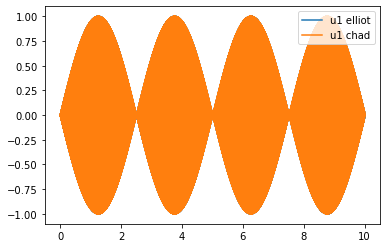

In [45]:
plt.figure()
plt.plot(t_elliot,u1_elliot_nint,label='u1 elliot')
plt.plot(t_elliot,u1_guess,label='u1 chad')
#plt.xlim(0,0.01)
plt.legend()
plt.show()

In [34]:
u1_error = linalg.norm(u1_guess - u1_elliot_nint) / linalg.norm(u1_elliot_nint)
w1_error = linalg.norm(w1_guess - w1_elliot_nint) / linalg.norm(w1_elliot_nint)

In [35]:
print(u1_error,w1_error)

0.028604211709997072 1.9349901977665515e-05


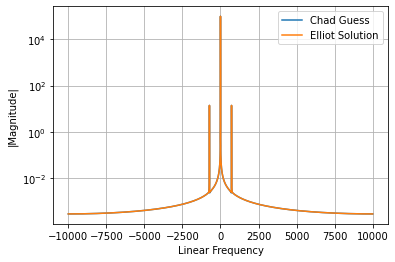

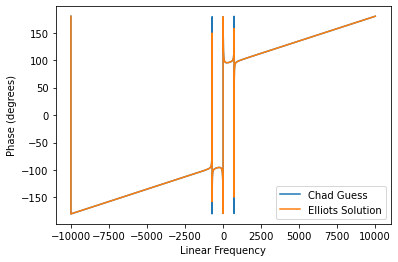

In [36]:
compare_frequency_spectra_solutions(w1_guess,w1_elliot_nint,t_elliot)

In [37]:
with timer():
    coeff = Newton(coefficients_guess,t_k,eps=1e-6)

iteration: 0 f mean 0.8899846882663137 f max 3.858729219407877
get_Jacobian: 0.0 minutes 0.01000070571899414 seconds
Jacobian Rank 246 Num unknowns 246
iteration: 1 f mean 1.2791511216269181e-12 f max 6.571938117245143e-12
Converged after 1 iterations
0.0 minutes 0.042000532150268555 seconds


In [38]:
u1_sol = gamma@coeff[:,0]
v1_sol = gamma@coeff[:,1]
w1_sol = gamma@coeff[:,2]
print(np.max(abs(u1_sol.imag)))
print(np.max(abs(v1_sol.imag)))
print(np.max(abs(w1_sol.imag)))

3.98170684650197e-12
3.983259264513014e-12
8.867271319917398e-12


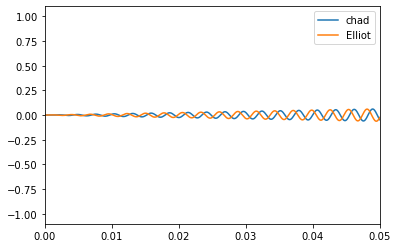

In [39]:
plt.figure()
plt.plot(t_elliot,u1_sol.real,label='chad')
plt.plot(t_elliot,u1_elliot_nint,label='Elliot')
plt.xlim(0,0.05)
plt.legend()
plt.show()

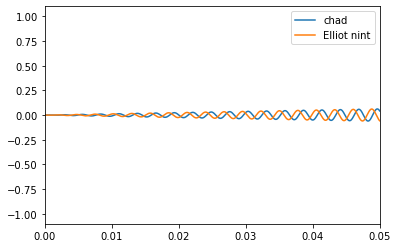

In [40]:
plt.figure()
plt.plot(t_elliot,v1_sol.real,label='chad')
plt.plot(t_elliot,v1_elliot_nint,label='Elliot nint')
#plt.plot(t_elliot,v1_elliot,label='Elliot')
plt.xlim(0,0.05)
plt.legend()
plt.show()

In [41]:
nint_error = linalg.norm(u1_elliot - u1_elliot_nint) / linalg.norm(u1_elliot_nint)
print(nint_error)

0.2683741078502731


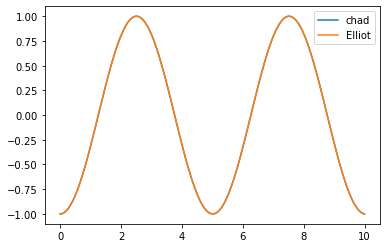

In [42]:
plt.figure()
plt.plot(t_elliot,w1_sol.real,label='chad')
plt.plot(t_elliot,w1_elliot_nint,label='Elliot')
#plt.xlim(0.3,0.5)
plt.legend()
plt.show()

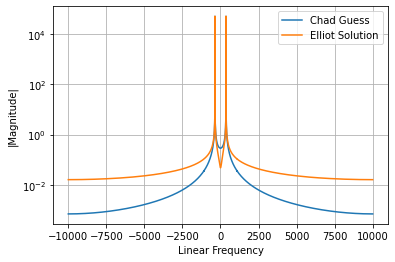

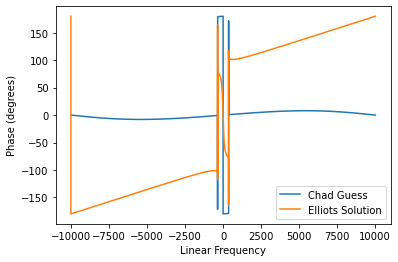

In [43]:
compare_frequency_spectra_solutions(u1_sol,u1_elliot_nint,t_elliot)

In [44]:
solution_error = linalg.norm(u1_sol - u1_elliot_nint) / linalg.norm(u1_elliot_nint)
print(solution_error)

1.589804859282108
